# SMus test

The goal of this notebook is to reproduce the results from https://arxiv.org/abs/2111.02383 for SMus using 18 more RV data points.



In [58]:
import sys

In [60]:
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
from scipy import interpolate
from PyAstronomy import pyasl
import matplotlib.pyplot as plt
from scipy import signal
import copy as cp
import pandas as pd

In [61]:
# One has to define how the observation files will be read and processed.
# This can be done using the load_spectrum_from_fits function in the ReadSpec.py file.

obs_data = Observations(survey="CORALIE", sample_rate=1, min_wv=5600, max_wv=5800)

for i in obs_data.time_series.vals:
    i = i.SpecPreProccess()

let's goooo
Selected directory: C:/Users/kentb/Desktop/PDM/SPARTA/examples/data/SMus
CORALIE.2012-01-12T08_22_46.000_s1d_A.fits
CORALIE.2012-01-13T07_21_29.000_s1d_A.fits
CORALIE.2012-01-15T07_39_04.000_s1d_A.fits
CORALIE.2012-01-17T08_13_32.000_s1d_A.fits
CORALIE.2012-01-18T08_17_11.000_s1d_A.fits
CORALIE.2012-01-19T06_20_39.000_s1d_A.fits
CORALIE.2012-01-20T06_50_12.000_s1d_A.fits
CORALIE.2012-01-22T05_16_05.000_s1d_A.fits
CORALIE.2012-01-24T08_49_29.000_s1d_A.fits
CORALIE.2012-01-25T06_40_40.000_s1d_A.fits
CORALIE.2012-03-19T04_53_09.000_s1d_A.fits
CORALIE.2012-03-22T03_01_06.000_s1d_A.fits
CORALIE.2012-03-26T06_34_58.000_s1d_A.fits
CORALIE.2012-06-09T02_48_39.000_s1d_A.fits
CORALIE.2012-06-10T02_20_03.000_s1d_A.fits
CORALIE.2012-06-11T02_30_02.000_s1d_A.fits
CORALIE.2012-06-13T23_33_55.000_s1d_A.fits
CORALIE.2012-06-15T01_54_39.000_s1d_A.fits
CORALIE.2013-03-31T03_22_35.000_s1d_A.fits
CORALIE.2013-04-01T04_35_50.000_s1d_A.fits
CORALIE.2013-04-02T03_10_08.000_s1d_A.fits
CORALIE.2013

[8.49913000e-01 1.81054800e+00 3.82000600e+00 5.84283400e+00
 6.84635500e+00 7.76558900e+00 8.78540800e+00 1.07218810e+01
 1.28706340e+01 1.37812590e+01 6.77095050e+01 7.06300020e+01
 7.47786520e+01 1.49624703e+02 1.50606322e+02 1.51612338e+02
 1.54491022e+02 1.55588537e+02 4.44644353e+02 4.45698901e+02
 4.46639359e+02 4.47861214e+02 4.48602070e+02 4.49851158e+02
 4.50688289e+02 4.51876320e+02 4.52851717e+02 4.53836916e+02
 4.56559161e+02 4.57728922e+02 4.58576974e+02 4.86567031e+02
 4.91595694e+02 4.94632548e+02 4.95628430e+02 4.96451710e+02
 7.18779642e+02 7.19778189e+02 7.20789920e+02 7.21751927e+02
 7.22751297e+02 7.28831366e+02 7.29832210e+02 7.30807358e+02
 7.31832637e+02 7.32833367e+02 7.60754707e+02 7.61757803e+02
 7.62691683e+02 7.63694802e+02 7.64687585e+02 7.65676733e+02
 7.66712435e+02 7.67708505e+02 7.68783086e+02 7.69705749e+02
 7.70772551e+02 7.71748596e+02 7.72756725e+02 7.73710211e+02
 1.21459314e+03 1.21459507e+03 1.21557725e+03 1.21658196e+03
 1.21760573e+03 1.218536

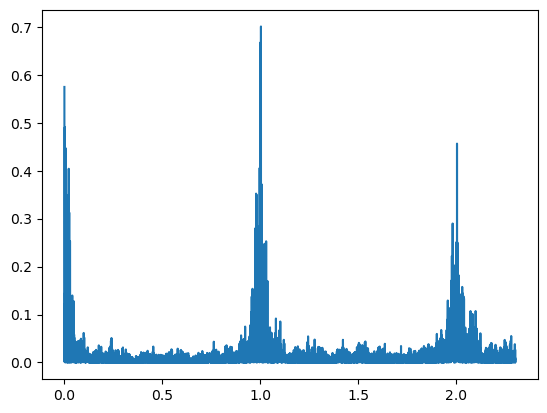

In [55]:
# times_differences = []
times = np.array(obs_data.time_series.times)
print(times)
nu = np.linspace(1/5000, 2.3, 100000)
spec_window = np.zeros(len(nu))
for i in range(len(spec_window)):
    spec_window[i] = np.abs(np.sum(np.exp(-2*np.pi*1j*nu[i]*times)))**2/len(times)**2
plt.plot(nu, spec_window)
peaks = signal.find_peaks(spec_window, height=0.5)
print(peaks)
# for i in range(len(obs_data.time_series.times)):
#     times_differences.append(int(obs_data.time_series.times[i] - obs_data.time_series.times[0]))
#     gcd.append(np.gcd(times_differences[i], times_differences[0]))
# print(times_differences)
# print(gcd)
# print(np.mean(times_differences))
# times_differences = np.array(times_differences)
# plt.stem(times_differences)
# print([t for t in obs_data.time_series.times])

In [56]:
print(nu[43474])

1.0000250502505026


### Using the already extracted RVs

In [62]:
# In this case, we chose to load a list of radial velocities calculated in advance.
# One can also calculate them using the UNICOR_quickstart.ipynb notebook.

df = pd.read_csv(r"C:\Users\kentb\Desktop\PDM\SPARTA\examples\examples\data\smus_rv.csv")
pre_calculated_vrads = df.rv.astype(float).values
BJD = df.bjd.astype(float).values
e_rv = df.e_rv.astype(float).values

# Checking if they are in the right order with respect to the time series.

new_bjd = (BJD-int(min(BJD)))

indices = []
for obs in obs_data.time_list:
    indices.append(next(i for i, val in enumerate(new_bjd) if np.isclose(val, obs, atol=1e-5, rtol=0)))

# Set the timeseries RV equal to the RV retrieved from starloader
obs_data.time_series.calculated_vrad_list = pre_calculated_vrads[indices]
obs_data.time_series.times = new_bjd[indices]

In [63]:
# Choosing frequency range and frequency resolution for the periodograms.
obs_data.initialize_periodicity_detector(freq_range=(1/5_000, 3/20), periodogram_grid_resolution=3_500) 

# Setting the known periods, so they are calculated in the plots
obs_data.periodicity_detector.period_truth = [9.65996, 41, 505]

done calc_GLS


done calc_PDC
done calc_USURPER
done calc shift_periodogram
done calc shape_periodogram


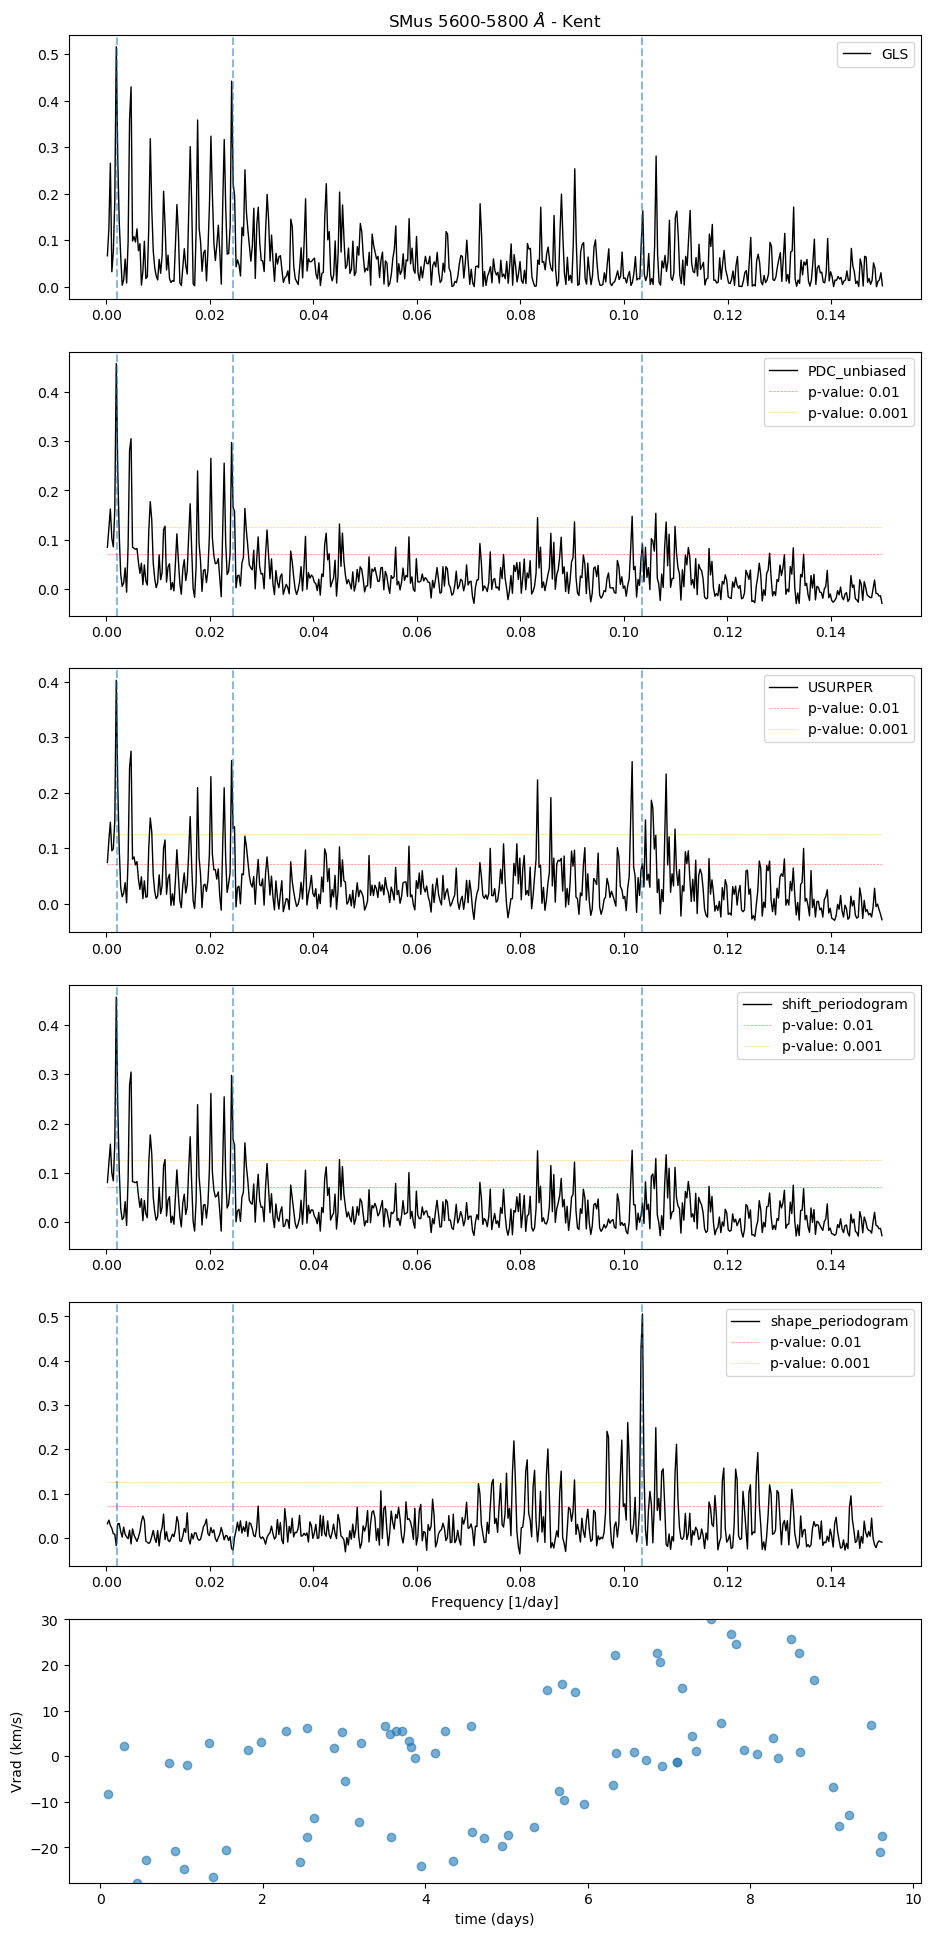

In [64]:
obs_data.periodicity_detector.calc_GLS()
print("done calc_GLS")

obs_data.periodicity_detector.calc_PDC(calc_biased_flag=False, calc_unbiased_flag=True)
print("done calc_PDC")

obs_data.periodicity_detector.calc_USURPER(calc_biased_flag=False, calc_unbiased_flag=True)
print("done calc_USURPER")



obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shift")
print("done calc shift_periodogram")

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shape")
print("done calc shape_periodogram")

obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-2,1e-3], plot_vals=True,title=r"SMus 5600-5800 $\AA$ - Kent")
plt.show()

Now let's do the same but by extracting the RVs from the spectra to check if we are indeed between 5600-5800 or 5800-6000.

In [65]:
obs_data_calc = Observations(survey="CORALIE", sample_rate=1, min_wv=5800, max_wv=6000, target_visits_lib=r"C:\Users\kentb\Desktop\PDM\SPARTA\examples\data\SMus")

let's goooo
Using target_visits_lib: C:\Users\kentb\Desktop\PDM\SPARTA\examples\data\SMus
Selected directory: C:\Users\kentb\Desktop\PDM\SPARTA\examples\data\SMus
CORALIE.2012-01-12T08_22_46.000_s1d_A.fits
CORALIE.2012-01-13T07_21_29.000_s1d_A.fits
CORALIE.2012-01-15T07_39_04.000_s1d_A.fits
CORALIE.2012-01-17T08_13_32.000_s1d_A.fits
CORALIE.2012-01-18T08_17_11.000_s1d_A.fits
CORALIE.2012-01-19T06_20_39.000_s1d_A.fits
CORALIE.2012-01-20T06_50_12.000_s1d_A.fits
CORALIE.2012-01-22T05_16_05.000_s1d_A.fits
CORALIE.2012-01-24T08_49_29.000_s1d_A.fits
CORALIE.2012-01-25T06_40_40.000_s1d_A.fits
CORALIE.2012-03-19T04_53_09.000_s1d_A.fits
CORALIE.2012-03-22T03_01_06.000_s1d_A.fits
CORALIE.2012-03-26T06_34_58.000_s1d_A.fits
CORALIE.2012-06-09T02_48_39.000_s1d_A.fits
CORALIE.2012-06-10T02_20_03.000_s1d_A.fits
CORALIE.2012-06-11T02_30_02.000_s1d_A.fits
CORALIE.2012-06-13T23_33_55.000_s1d_A.fits
CORALIE.2012-06-15T01_54_39.000_s1d_A.fits
CORALIE.2013-03-31T03_22_35.000_s1d_A.fits
CORALIE.2013-04-01T0

In [91]:
selected_ords = [10+I for I in np.arange(40)]
print(selected_ords)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [66]:
# # Keep only the required orders
# selected_ords = [10+I for I in np.arange(40)]
# obs_data_calc.SelectOrders(
#     selected_ords, 
#     remove=False)

# Remove NaNs, trim edges, remove cosmics:
# ---------------------------------------
RemoveNaNs = True     # Remove NaN values.
CleanMargins = True   # Cut the edges of the observed spectra. Remove zero padding.
#Ntrim = 100           # Number of pixels to cut from each side of the spectrum.
RemCosmicNum = 2      # Number of sigma of outlier rejection. Only points that deviate upwards are rejected.

# Interpolate the spectrum to evenly sampled bins:
# ------------------------------------------------
delta = 0.5           # 0.5 is equivalent to oversampling of fator 2.

# Interpolate the spectrum to evenly sampled bins:
# ------------------------------------------------
FilterLC = 4           # Stopband freq for low-pass filter. In units of the minimal frequency (max(w)-min(w))**(-1)
FilterHC = 0.15        # Stopband freq for the high-pass filter. In units of the Nyquist frequency.
order = 1              # The order of the Butterworth filter (integer) This corresponds to the slope of the filter in the log-log plot.
                       # That's -20 dB/decade(when freq are decupled) for order=1, -40 dB/decade for order=2, etc. 

# Apply cosine-bell:
# ------------------
alpha = 0.3            # Shape parameter of the Tukey window
            
obs_data_calc.PreProccessSpectra(CleanMargins=CleanMargins, RemoveNaNs=RemoveNaNs,
                            delta=delta, RemCosmicNum=RemCosmicNum, FilterLC=FilterLC, FilterHC=FilterHC,
                            alpha=alpha, verbose=True)

  0%|          | 0/78 [00:00<?, ?it/s]

100%|██████████| 78/78 [02:21<00:00,  1.82s/it]


In [67]:
from sparta.UNICOR.Template import Template

# Retrieve the template.
# If the template is not located in a local directory 
# it will be downloaded from the PHOENIX FTP:
template = Template(temp=5800, 
                    log_g=3.5, 
                    metal=0.5, 
                    alpha=0.0, 
                    min_val=4650, 
                    max_val=7500,
                    air=True)

# Bin the template, to reduce computational strain:
print('Integrating.', end=' ')
template.integrate_spec(integration_ratio=3)

# Make sure that the data are evenly sampled.
# No over sampling required, so the delta=1 (because when delta<1 sp is oversampled)
print('Interpolating.', end=' ')
template.model.InterpolateSpectrum(delta=1)

# Apply rotational broadening of 6 km/s:
print('Rotating.', end=' ')
template.RotationalBroadening(vsini=6, epsilon=0.5)

# Instrumental broadening for R=53,000
print('Broadening.', end=' ')
template.GaussianBroadening(resolution=53000)

# Cut the template like the observed spectrum
print('Cutting to fit spectra.', end=' ')
template.cut_multiorder_like(obs_data_calc.spec_list[0], margins=150)

# Filter the spectrum Just like the observations were filtered:
template.model.SpecPreProccess(CleanMargins=True, RemoveNaNs=True,
                               delta=0.5, RemCosmicNum=2, FilterLC=4, FilterHC=0.15, alpha=0.3)

print('Done.')

Integrating. Interpolating. Rotating. Broadening. Cutting to fit spectra. Done.


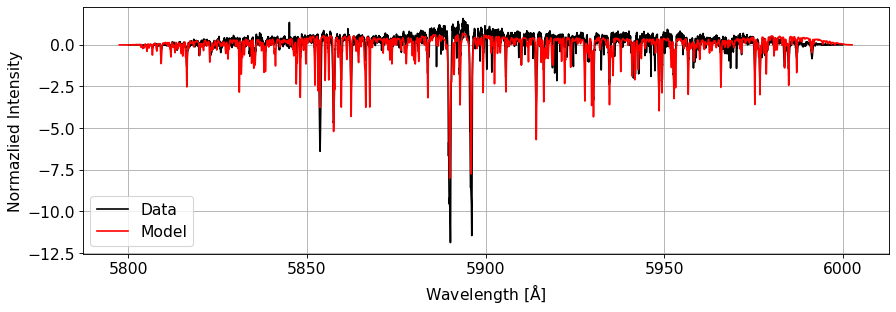

In [68]:
# Plot the resulting spectrum
plt.rcParams.update({'font.size': 14})

# plot order 0
plt.figure(figsize=(13, 4), dpi= 80, facecolor='w', edgecolor='k')
ax1 = plt.plot(obs_data_calc.spec_list[0].wv[0], obs_data_calc.spec_list[0].sp[0], 'k', label='Data')
ax2 = plt.plot(template.model.wv[0], template.model.sp[0], 'r', label='Model')

plt.xlabel(r'Wavelength [${\rm \AA}$]')
plt.ylabel(r'Normazlied Intensity')
plt.legend()
plt.grid()

In [69]:
# Set the correlation velocity resolution and bounds.
# ---------------------------------------------------
dv = 0.05          # Assumed to be in km/s unless provided as an Astropy Unit.

# Set the velocity range for analysis:
# -----------------------------------
VelBound = [-100, 50] # Boundaries for the cross correlation.

obs_data_calc.calc_rv_against_template(template, dv=dv, VelBound=VelBound, err_per_ord=False, combine_ccfs=True, fastccf=True)
obs_data_calc.time_series.calculated_vrad_list = obs_data_calc.vels

100%|██████████| 78/78 [00:08<00:00,  8.80it/s]


In [70]:
# replace nan by 0
# if np.isnan(obs_data_calc.time_series.calculated_vrad_list).any():
#     obs_data_calc.time_series.calculated_vrad_list = np.nan_to_num(obs_data_calc.time_series.calculated_vrad_list)
# for i in range(len(obs_data_calc.time_series.calculated_vrad_list)):
#     if obs_data_calc.time_series.calculated_vrad_list[i]>100:
#         obs_data_calc.time_series.calculated_vrad_list[i] = 0
print(obs_data_calc.time_series.calculated_vrad_list)

#print(obs_data.time_series.calculated_vrad_list)

[ -0.14572458   2.24499222   2.7973265   14.3968172   22.98497857
  27.68353045  16.97076614  -0.69592691   3.78718895   1.58189138
  -7.14728728  -4.16603168  15.57837098 -16.97986617  -8.58640464
   0.6452115  -19.56735245 -23.26200837   3.1872789    3.62382326
   6.16987718   7.09823617   6.17661917  14.6227639   22.50371504
  31.49628647  26.35188478   7.28691723   6.88123729   6.23729493
   7.40547769   5.39291781  22.82913268   3.78019861   5.99428888
   4.03959661 -22.55818725 -18.49800659  -9.3222335   -0.32855372
   3.87796377 -21.63261803 -14.65710725  -5.16479396   2.84446275
   1.95174296   6.08054594   6.01804324 -11.75653368 -21.12008307
 -19.25913476 -16.65012107 -16.46109527 -15.73784286  -6.26899148
   2.35105677   8.65006721   3.1296561  -16.068662   -19.42841773
   0.30914821   0.50995482   2.71295315 -13.76871026 -26.10885437
 -24.97929015 -21.83681255   2.74014485   0.70098206  20.97370893
  25.51190747   6.06782671  16.16986822 -16.10740195  -4.82676671
 -13.38594

Try redoing the plots without the nan and absurd values.

In [73]:
# Choosing frequency range and frequency resolution for the periodograms.
obs_data_calc.initialize_periodicity_detector(freq_range=(1/5000, 3/20), periodogram_grid_resolution=7_000) 

# Setting the known periods, so they are calculated in the plots
obs_data_calc.periodicity_detector.period_truth = [9.65996, 41, 505]

done calc_GLS
done calc_PDC
done calc_USURPER
done calc shift_periodogram
done calc shape_periodogram


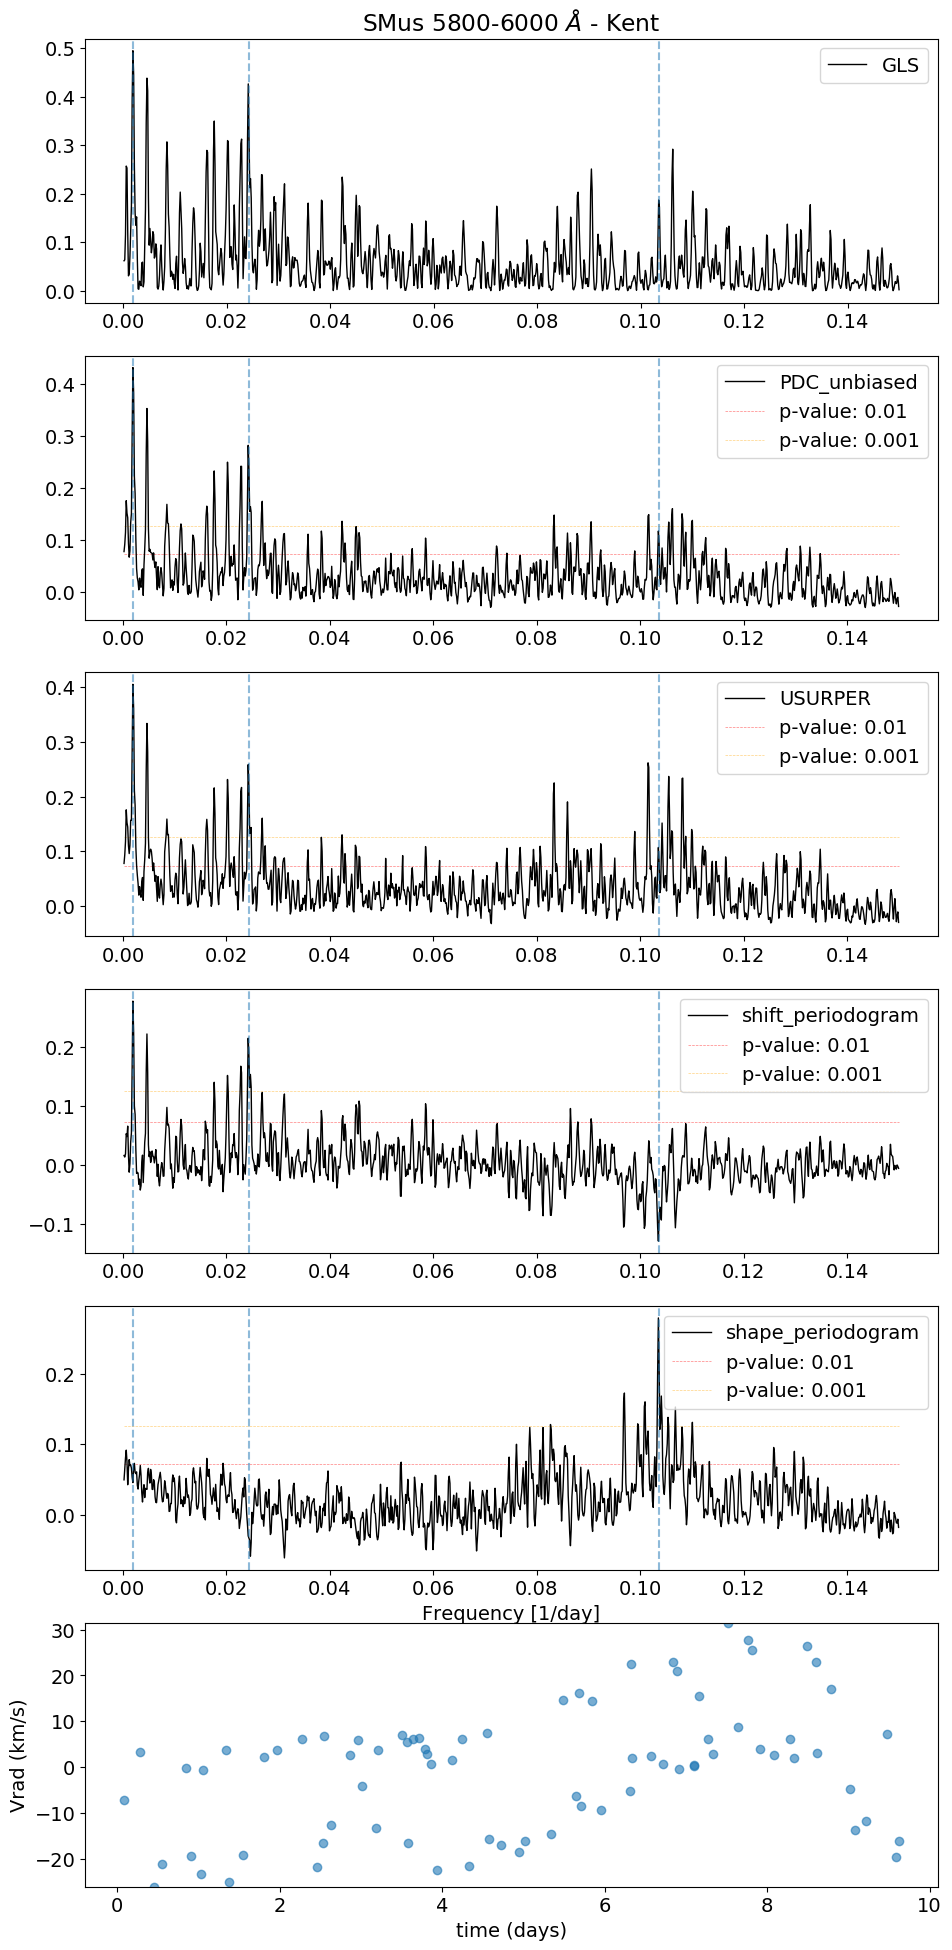

In [74]:
obs_data_calc.periodicity_detector.calc_GLS()
print("done calc_GLS")

obs_data_calc.periodicity_detector.calc_PDC(calc_biased_flag=False, calc_unbiased_flag=True)
print("done calc_PDC")

obs_data_calc.periodicity_detector.calc_USURPER(calc_biased_flag=False, calc_unbiased_flag=True)
print("done calc_USURPER")



obs_data_calc.periodicity_detector.calc_partial_periodogram(partial_type="shift")
print("done calc shift_periodogram")

obs_data_calc.periodicity_detector.calc_partial_periodogram(partial_type="shape")
print("done calc shape_periodogram")

obs_data_calc.periodicity_detector.plot_periodograms(annotate_pval=[1e-2,1e-3], plot_vals=True,title=r"SMus 5800-6000 $\AA$ - Kent")
plt.show()